# Supply Chain Resilience Data Analysis

This notebook analyzes a supply chain resilience dataset and answers several questions about order delays, disruptions, risk exposure and logistics strategies. The aim is to demonstrate a complete data analytics workflow including data wrangling, descriptive statistics, visualization, and insights interpretation.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('supply_chain_resilience_dataset.csv')
print('Dataset shape:', df.shape)
print(df.head())
print(df.columns)

Dataset shape: (1000, 24)
  Order_ID Buyer_ID Supplier_ID Product_Category  Quantity_Ordered  \
0    O1000      B33         S23         Textiles               469   
1    O1001       B1         S20        Machinery               365   
2    O1002       B2         S10             Food               333   
3    O1003       B6         S10        Machinery               142   
4    O1004       B5          S4        Machinery               897   

   Order_Date Dispatch_Date Delivery_Date Shipping_Mode  Order_Value_USD  ...  \
0  2023-10-24    2023-10-27    2023-10-28          Rail         36273.99  ...   
1  2023-07-07    2023-07-08    2023-07-09          Road         34780.36  ...   
2  2023-12-28    2023-12-29    2024-01-07          Rail          7154.54  ...   
3  2023-01-14    2023-01-17    2023-01-20          Rail         15320.08  ...   
4  2023-01-12    2023-01-14    2023-01-16          Road         18256.42  ...   

   Supplier_Reliability_Score Organization_ID Dominant_Buyer_Flag 

## Data Cleaning and Preprocessing

In [3]:
#Convert date columns to datetime
for col in ["Order_Date", "Dispatch_Date", "Delivery_Date"]:
  df[col] = pd.to_datetime(df[col])

#Fill missing disruption values with None
df['Disruption_Type'] = df['Disruption_Type'].fillna('None')
df['Disruption_Severity'] = df['Disruption_Severity'].fillna('None')

missing = df.isnull().sum()
print(missing[missing > 0])

Series([], dtype: int64)


## Order Lifecycle Durations and Delay Correlation

In [4]:
#Compute Durations
df['Order_to_Dispatch_Days'] = (df['Dispatch_Date'] - df['Order_Date']).dt.days
df['Dispatch_to_Delivery_Days'] = (df['Delivery_Date'] - df['Dispatch_Date']).dt.days

#Correlation Matrix
corr = df[['Order_to_Dispatch_Days', 'Dispatch_to_Delivery_Days', 'Delay_Days']].corr()
print(corr)

                           Order_to_Dispatch_Days  Dispatch_to_Delivery_Days  \
Order_to_Dispatch_Days                   1.000000                   0.001423   
Dispatch_to_Delivery_Days                0.001423                   1.000000   
Delay_Days                               0.007702                   0.757253   

                           Delay_Days  
Order_to_Dispatch_Days       0.007702  
Dispatch_to_Delivery_Days    0.757253  
Delay_Days                   1.000000  


### Average Duration by Shipping Mode

               Order_to_Dispatch_Days  Dispatch_to_Delivery_Days  Delay_Days
Shipping_Mode                                                               
Air                              2.57                       6.76        1.76
Rail                             2.47                       6.88        2.04
Road                             2.57                       6.88        1.95
Sea                              2.60                       7.18        2.04


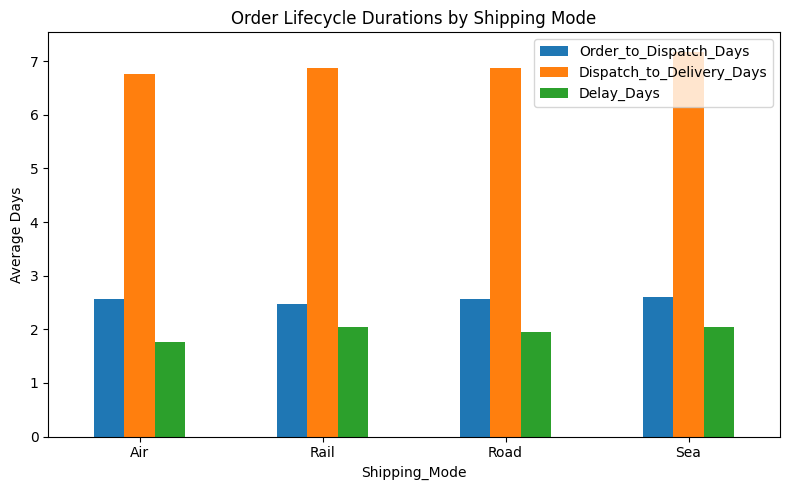

In [5]:
summary = df.groupby('Shipping_Mode')[['Order_to_Dispatch_Days','Dispatch_to_Delivery_Days','Delay_Days']].mean().round(2)
print(summary)

summary[['Order_to_Dispatch_Days','Dispatch_to_Delivery_Days','Delay_Days']].plot(kind = 'bar', figsize = (8, 5))
plt.ylabel('Average Days')
plt.title('Order Lifecycle Durations by Shipping Mode')
plt.xticks(rotation = 0)
plt.tight_layout()

## Delay Analysis

               count  mean  median  max  min
Shipping_Mode                               
Air              263  1.76     0.0   10    0
Rail             255  2.04     1.0   10    0
Road             256  1.95     1.0   10    0
Sea              226  2.04     1.0   10    0


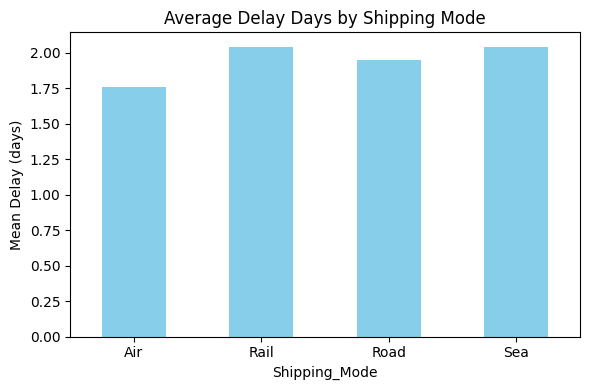

In [6]:
delay_stats = df.groupby('Shipping_Mode')['Delay_Days'].agg(['count','mean','median','max','min']).round(2)
print(delay_stats)

delay_stats['mean'].plot(kind='bar', figsize=(6,4), color='skyblue')
plt.title('Average Delay Days by Shipping Mode')
plt.ylabel('Mean Delay (days)')
plt.xticks(rotation=0)
plt.tight_layout()

## Delay by Product Category

Product_Category
Textiles       2.11
Pharma         2.08
Electronics    2.08
Machinery      1.74
Food           1.71
Name: Delay_Days, dtype: float64


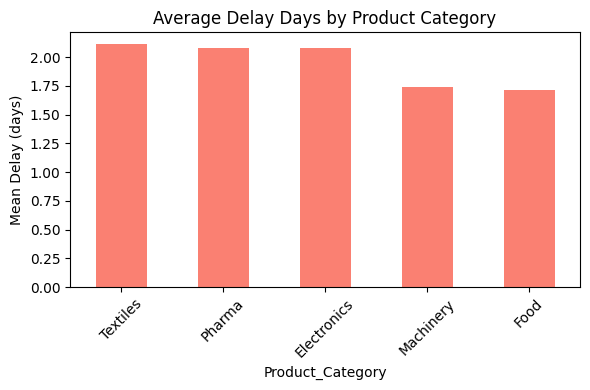

In [7]:
avg_delay_by_category = df.groupby('Product_Category')['Delay_Days'].mean().sort_values(ascending=False).round(2)
print(avg_delay_by_category)

avg_delay_by_category.plot(kind='bar', figsize=(6,4), color='salmon')
plt.title('Average Delay Days by Product Category')
plt.ylabel('Mean Delay (days)')
plt.xticks(rotation=45)
plt.tight_layout()

## Seasonal Pattern in Delays

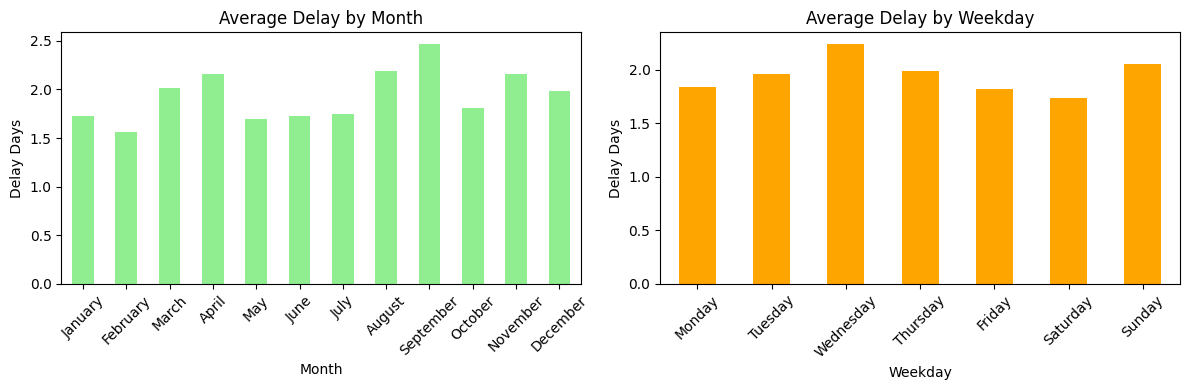

In [8]:
df['Month'] = df['Order_Date'].dt.month_name()
df['Weekday'] = df['Order_Date'].dt.day_name()
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
month_delay = df.groupby('Month')['Delay_Days'].mean().reindex(month_order)
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_delay = df.groupby('Weekday')['Delay_Days'].mean().reindex(weekday_order)

fig, ax = plt.subplots(1,2, figsize=(12,4))
month_delay.plot(kind='bar', ax=ax[0], color='lightgreen')
ax[0].set_title('Average Delay by Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Delay Days')
ax[0].tick_params(axis='x', labelrotation=45)
weekday_delay.plot(kind='bar', ax=ax[1], color='orange')
ax[1].set_title('Average Delay by Weekday')
ax[1].set_xlabel('Weekday')
ax[1].set_ylabel('Delay Days')
ax[1].tick_params(axis ='x', labelrotation=45)
plt.tight_layout()

## Disruption Patterns

Disruption_Type
None        486
Shortage    135
Weather     133
Customs     124
Strike      122
Name: count, dtype: int64


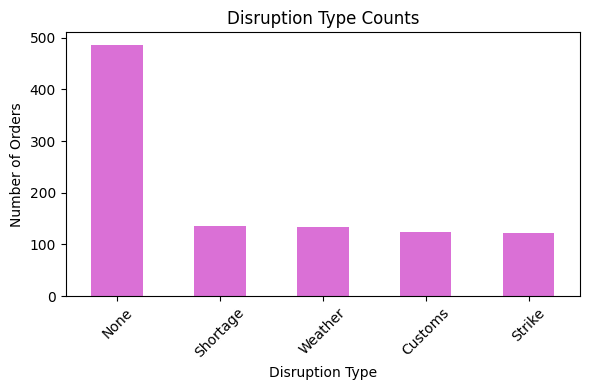

In [9]:
disruption_counts = df['Disruption_Type'].value_counts()
print(disruption_counts)

disruption_counts.plot(kind='bar', figsize=(6,4), color='orchid')
plt.title('Disruption Type Counts')
plt.xlabel('Disruption Type')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()

Disruption_Type
Weather     3.87
Shortage    3.79
Customs     3.75
Strike      3.70
None        0.00
Name: Delay_Days, dtype: float64


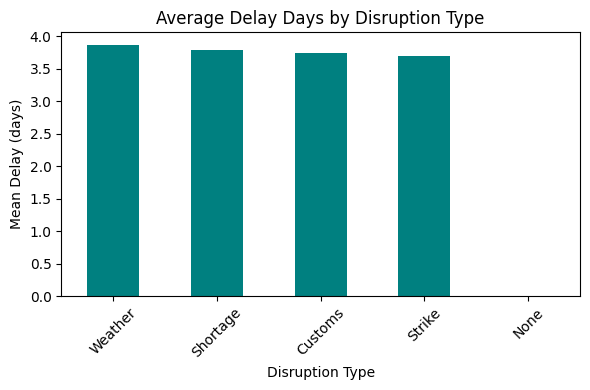

In [10]:
avg_delay_disruption = df.groupby('Disruption_Type')['Delay_Days'].mean().sort_values(ascending=False).round(2)
print(avg_delay_disruption)

avg_delay_disruption.plot(kind='bar', figsize=(6,4), color='teal')
plt.title('Average Delay Days by Disruption Type')
plt.xlabel('Disruption Type')
plt.ylabel('Mean Delay (days)')
plt.xticks(rotation=45)
plt.tight_layout()

## Shipping Mode vs Disruption Pattern

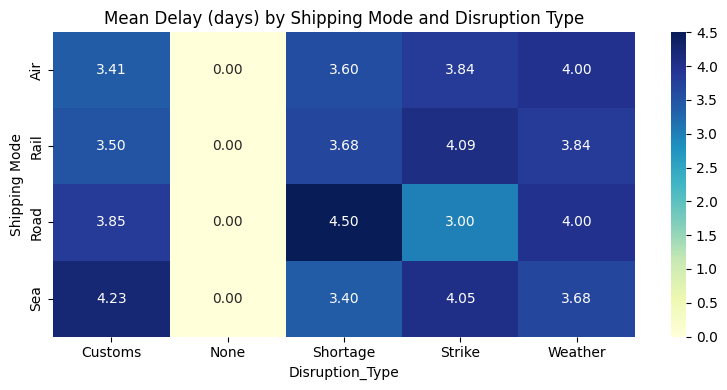

In [11]:
pivot = df.pivot_table(index='Shipping_Mode', columns='Disruption_Type', values='Delay_Days', aggfunc='mean')
pivot.round(2)

plt.figure(figsize=(8,4))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Mean Delay (days) by Shipping Mode and Disruption Type')
plt.ylabel('Shipping Mode')
plt.tight_layout()

## Supplier and Buyer Behaviour

In [12]:
# Supplier stats
supplier_stats = df.groupby('Supplier_ID').apply(lambda x: pd.Series({
    'total_orders': len(x),
    'disruption_rate': (x['Disruption_Type']!='None').mean(),
    'risk_rate': x['Supply_Risk_Flag'].mean()
})).sort_values('disruption_rate', ascending=False)
print(supplier_stats.head(10))

# Buyer stats
df['Disruption_Flag'] = (df['Disruption_Type']!='None').astype(int)
buyer_stats = df.groupby('Buyer_ID').agg(total_orders=('Order_ID','count'), disruption_rate=('Disruption_Flag','mean'), risk_rate=('Supply_Risk_Flag','mean'))
print(buyer_stats.sort_values('disruption_rate', ascending=False).head(10))

             total_orders  disruption_rate  risk_rate
Supplier_ID                                          
S21                  26.0         0.692308   0.692308
S15                  22.0         0.636364   0.636364
S2                   26.0         0.615385   0.615385
S29                  35.0         0.600000   0.600000
S5                   32.0         0.593750   0.593750
S18                  29.0         0.586207   0.586207
S6                   26.0         0.576923   0.576923
S8                   28.0         0.571429   0.571429
S4                   42.0         0.571429   0.571429
S17                  30.0         0.566667   0.566667
          total_orders  disruption_rate  risk_rate
Buyer_ID                                          
B42                 19         0.684211   0.684211
B43                 18         0.666667   0.666667
B39                 20         0.650000   0.650000
B25                 22         0.636364   0.636364
B38                 16         0.625000   0.62

/tmp/ipython-input-3852216923.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  supplier_stats = df.groupby('Supplier_ID').apply(lambda x: pd.Series({


## Risk and Exposure Analytics

Risk_Group
Low Risk       486
Medium Risk    337
High Risk      177
Name: count, dtype: int64


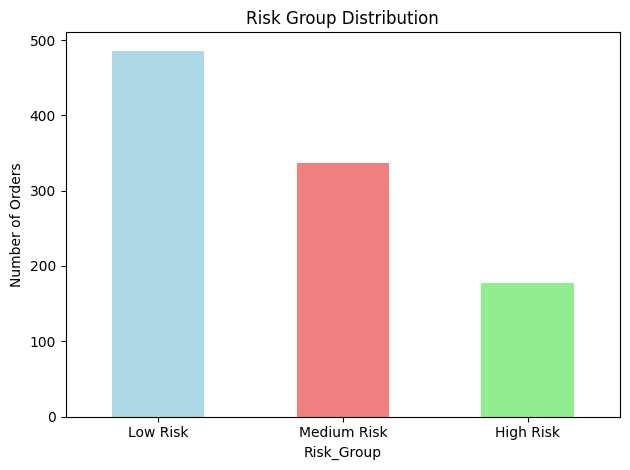

In [13]:
conditions = [(df['Delay_Days']==0), (df['Delay_Days'].between(1,3)), (df['Delay_Days']>3)]
choices = ['On-time','Moderate','Severe']
df['Delay_Severity'] = np.select(conditions, choices, default='Not Classified')

conditions_risk = [
    (df['Supply_Risk_Flag']==1) & (df['Delay_Severity']=='Severe'),
    (df['Supply_Risk_Flag']==1) & (df['Delay_Severity']=='Moderate'),
    (df['Supply_Risk_Flag']==0) | (df['Delay_Severity']=='On-time')
]
groups = ['High Risk','Medium Risk','Low Risk']
df['Risk_Group'] = np.select(conditions_risk, groups, default='Medium Risk')

risk_counts = df['Risk_Group'].value_counts()
print(risk_counts)

risk_counts.plot(kind='bar', color=['lightblue','lightcoral','lightgreen'])
plt.title('Risk Group Distribution')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.tight_layout()

## Risk by Shipping Mode and Product Category

Product_Category  Electronics      Food  Machinery    Pharma  Textiles
Shipping_Mode                                                         
Air                  0.510638  0.471698   0.384615  0.438596  0.574074
Rail                 0.500000  0.590909   0.508197  0.538462  0.577778
Road                 0.520000  0.531915   0.517241  0.522727  0.473684
Sea                  0.510638  0.543478   0.575758  0.520000  0.540000


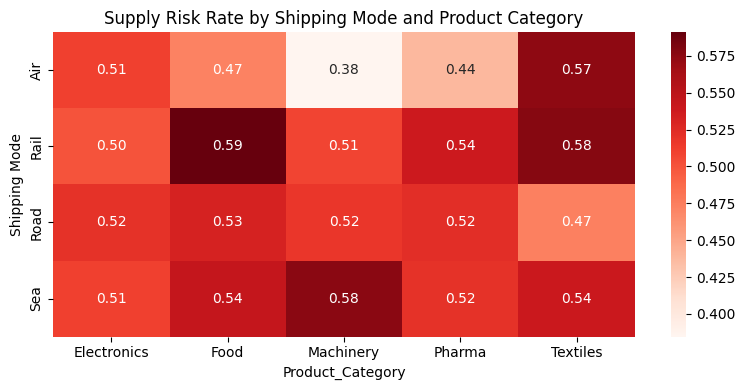

In [14]:
risk_pivot = df.pivot_table(index='Shipping_Mode', columns='Product_Category', values='Supply_Risk_Flag', aggfunc='mean')
print(risk_pivot)

plt.figure(figsize=(8,4))
sns.heatmap(risk_pivot, annot=True, fmt='.2f', cmap='Reds')
plt.title('Supply Risk Rate by Shipping Mode and Product Category')
plt.ylabel('Shipping Mode')
plt.tight_layout()

## Operational Characteristics and Risk

In [15]:
# Correlations
corr_energy_delay = df['Energy_Consumption_Joules'].corr(df['Delay_Days'])
corr_energy_risk = df['Energy_Consumption_Joules'].corr(df['Supply_Risk_Flag'])
corr_comm_risk = df['Communication_Cost_MB'].corr(df['Supply_Risk_Flag'])
print(corr_energy_delay, corr_energy_risk, corr_comm_risk)

# High vs low energy
median_energy = df['Energy_Consumption_Joules'].median()
df['Energy_High'] = df['Energy_Consumption_Joules'] > median_energy
energy_delay = df.groupby('Energy_High')['Delay_Days'].mean()
energy_risk = df.groupby('Energy_High')['Supply_Risk_Flag'].mean()
print(energy_delay, energy_risk)

# High vs low communication
median_comm = df['Communication_Cost_MB'].median()
df['Comm_High'] = df['Communication_Cost_MB'] > median_comm
comm_risk = df.groupby('Comm_High')['Supply_Risk_Flag'].mean()
print(comm_risk)

0.062272503718328404 0.041935352783646844 -0.02496317853918483
Energy_High
False    1.726
True     2.160
Name: Delay_Days, dtype: float64 Energy_High
False    0.476
True     0.552
Name: Supply_Risk_Flag, dtype: float64
Comm_High
False    0.527888
True     0.500000
Name: Supply_Risk_Flag, dtype: float64


## High Value Orders and Risk

In [16]:
threshold = df['Order_Value_USD'].quantile(0.75)
high_value = df[df['Order_Value_USD'] > threshold]
low_value = df[df['Order_Value_USD'] <= threshold]
hv_risk = high_value['Supply_Risk_Flag'].mean()
lv_risk = low_value['Supply_Risk_Flag'].mean()
print(hv_risk, lv_risk)

0.552 0.5013333333333333


## Conclusions

From this analysis on the supply chain resilience dataset:

- **Order lifecycle delays** are primarily driven by the dispatch-to-delivery stage rather than order-to-dispatch, as shown by the high correlation (~0.76).
- **Shipping modes**: Air transport has the lowest average delay and energy consumption, while Sea and Rail exhibit longer delays and higher risk rates.
- **Product categories**: Textiles, Pharma and Electronics suffer higher average delays. Combining certain products with specific modes (e.g., Textiles by Air or Pharma by Rail) results in above-average delays.
- **Seasonality**: Delays peak around September and November and mid-week (especially Wednesday).
- **Disruptions**: The most common disruption types are Shortage, Weather, Customs and Strike. Each disruption type adds ~3.7–3.9 days of delay versus orders with no disruption. Sea + Customs and Road + Shortage combinations show particularly long delays.
- **Supplier and buyer behaviour**: A few suppliers (e.g., S21, S15, S2, S29) and buyers (e.g., B42, B43, B39) experience disproportionate disruption and risk rates, but overall supplier reliability scores are not strongly correlated with delays or risk. Dominant buyers face fewer delays and lower risk.
- **Risk segmentation**: About 48.6% of orders are on time (low risk), 33.7% moderate risk (1–3 day delays) and 17.7% high risk (delays >3 days with flagged risk). High‑risk orders tend to have higher order values, slightly lower supplier reliability and higher energy consumption.
- **Operational characteristics**: Higher energy consumption and lower communication cost are associated with slightly higher delays and risk. Encouraging better communication and energy‑efficient logistics could reduce risk exposure.
- **High-value orders**: Approximately 55% of high‑value orders are flagged as risky versus 50% for low‑value orders, suggesting more stringent risk management is needed for expensive shipments.

These insights can inform strategic decisions such as prioritising Air shipping for high-value goods, avoiding problematic mode‑category combinations, monitoring high‑risk suppliers and buyers, and investing in communication and energy efficiency improvements.